In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
source(here("src/utils.R"))

In [3]:
# Calculate T_MRCA of all pairs of Africans and non-Africans, using a set
# of EMHs of known age for branch shortening-based mutation rate estimation.
calculate_tAfrRef <- function(gt, samples) {
    refs <- filter(samples, pop != "Africa", pop != "EMH")$name
    afrs <- filter(samples, pop == "Africa")$name
    emhs <- filter(samples, pop == "EMH")$name

    map_dfr(refs, function(ref) {
        map_dfr(afrs, function(afr) {
            map_dfr(emhs, function(emh) {
                sum_patterns(gt, w = "chimp", x = afr, y = ref, z = emh) %>%
                    mutate(ref = ref, afr = afr, emh = emh)
            })
        })
    }) %>%
    inner_join(samples, by = c("emh" = "name")) %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2
    )
}

In [93]:
# Calculate T_MRCA of each of the specified archaic individuals
# with modern human Y chromosomes.
calculate_tArchRef <- function(gt, samples, tAfrRef) {
    refs <- filter(samples, pop != "Africa", pop != "EMH")$name
    afrs <- filter(samples, pop == "Africa")$name
    archaics <- colnames(select(gt, -c(chrom, pos, REF, ALT, chimp), -one_of(samples$name)))

    tAfrRef_ui <- filter(tAfrRef, emh == "ustishim") %>%
        select(afr, ref, mut_rate, tmrca_ad, tmrca_f, tmrca_avg)

    map_dfr(refs, function(ref) {
        map_dfr(afrs, function(afr) {
            map_dfr(archaics, function(arch) {
                sum_patterns(gt, w = "chimp", x = arch, y = ref, z = afr) %>%
                    mutate(arch = arch, afr = afr, ref = ref)
            })
        })
    }) %>% inner_join(tAfrRef_ui, by = c("afr", "ref")) %>%
    mutate(p = a / (a + d + e),
           alpha = (1 + p) / (1 - p),
           tmrca_arch = tmrca_avg * alpha) %>%
    select(arch, afr, ref, tmrca_arch, alpha, mut_rate, tmrca_ad, tmrca_f, tmrca_avg, everything())
}

# Full Y capture

In [5]:
gt_full <- read_gt(here("data/vcf/merged_full.vcf.gz"))

In [6]:
samples_full <- sample_info(gt_full)

In [8]:
tAfrRef_full <- calculate_tAfrRef(gt_full, samples_full)

In [9]:
tAfrRef_full %>% filter(emh == "ustishim") %>% group_by(afr) %>% summarise_at(vars(mut_rate, starts_with("tmrca")), mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,7.228527e-10,279009.05,238462.64,258735.85
S_Dinka_1,7.303452e-10,70941.93,69349.19,70145.56
S_Gambian_1,7.316987e-10,71880.86,68641.57,70261.21
S_Ju_hoan_North_1,7.275020e-10,104537.82,95647.17,100092.49
S_Mandenka_1,7.251100e-10,74288.73,69789.21,72038.97
S_Mbuti_1,7.279549e-10,73608.19,74893.45,74250.82
S_Yoruba_2,7.275214e-10,73464.66,69555.03,71509.84


In [94]:
tArchRef_full <- calculate_tArchRef(gt_full, samples_full, tAfrRef_full)

In [95]:
tArchRef_full %>% group_by(arch) %>% summarise_at(vars(tmrca_arch, alpha, mut_rate), mean)

arch,tmrca_arch,alpha,mut_rate
comb_neand,339775.8,3.999934,7.275693e-10
den8,643847.0,7.658384,7.275693e-10
mez2,354969.8,4.188505,7.275693e-10
spy1,301858.0,3.490244,7.275693e-10


In [89]:
tArchRef_full %>% group_by(arch) %>% summarise_at(vars(tmrca_arch, alpha, mut_rate), mean)

arch,tmrca_arch,alpha,mut_rate
comb_neand,339991.4,3.999934,7.275693e-10
den8,643790.0,7.658384,7.275693e-10
mez2,355016.6,4.188505,7.275693e-10
spy1,302096.4,3.490244,7.275693e-10


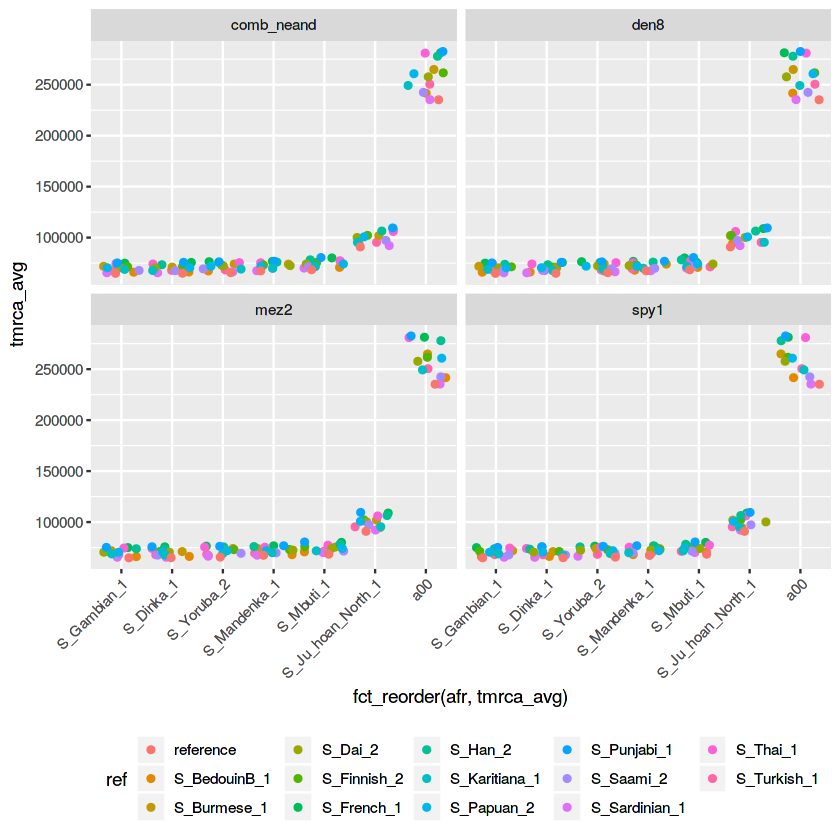

In [103]:
ggplot(tArchRef_full, aes(fct_reorder(afr, tmrca_avg), tmrca_avg, color = ref)) +
    geom_jitter() +
    facet_wrap(~ arch) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

# Full Y capture - removing C-T/G-A SNPs

In [20]:
gt_full_tv <- read_gt(here("data/vcf/merged_full.vcf.gz"), tv_only = TRUE)

In [25]:
tAfrRef_full_tv <- calculate_tAfrRef(gt_full_tv, samples_full)

In [29]:
tAfrRef_full_tv %>% filter(emh == "ustishim") %>% group_by(afr) %>% summarise_at(vars(mut_rate, starts_with("tmrca")), mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,4.814816e-10,305501.71,246949.70,276225.70
S_Dinka_1,4.866444e-10,73550.90,66996.22,70273.56
S_Gambian_1,4.877201e-10,72799.41,71044.05,71921.73
S_Ju_hoan_North_1,4.850916e-10,113854.19,96495.49,105174.84
S_Mandenka_1,4.826821e-10,75407.80,70277.16,72842.48
S_Mbuti_1,4.865116e-10,75201.04,74559.42,74880.23
S_Yoruba_2,4.883002e-10,74196.43,70970.26,72583.35


In [26]:
tArchRef_full_tv <- calculate_tArchRef(gt_full_tv, samples_full, tAfrRef_full_tv)

In [46]:
tArchRef_full_tv %>% group_by(arch) %>% summarise_at(vars(tmrca_arch, alpha, mut_rate), mean)

arch,tmrca_arch,alpha,mut_rate
comb_neand,343719.8,3.940613,4.854902e-10
den8,658646.3,7.637777,4.854902e-10
mez2,373074.7,4.316872,4.854902e-10
spy1,302175.8,3.442238,4.854902e-10


# Exome Y capture

In [34]:
gt_exome <- read_gt(here("data/vcf/merged_exome.vcf.gz"))

In [35]:
samples_exome <- sample_info(gt_exome)

In [36]:
tAfrRef_exome <- calculate_tAfrRef(gt_exome, samples_exome)

In [37]:
tAfrRef_exome %>% filter(emh == "ustishim") %>% group_by(afr) %>% summarise_at(vars(mut_rate, starts_with("tmrca")), mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,8.882523e-10,238178.57,219971.94,229075.26
S_Dinka_1,8.656269e-10,72811.22,109637.76,91224.49
S_Gambian_1,8.771406e-10,86395.41,68992.35,77693.88
S_Ju_hoan_North_1,8.789377e-10,72596.94,122579.08,97588.01
S_Mandenka_1,8.908849e-10,86165.82,68609.69,77387.76
S_Mbuti_1,8.911874e-10,86165.82,68609.69,77387.76
S_Yoruba_2,8.952733e-10,72443.88,68609.69,70526.79


In [38]:
tArchRef_exome <- calculate_tArchRef(gt_exome, samples_exome, tAfrRef_exome)

In [75]:
tArchRef_exome %>% group_by(arch) %>% summarise_at(vars(tmrca_arch, alpha, mut_rate), mean)

arch,tmrca_arch,alpha,mut_rate
comb_neand,Inf,Inf,8.839004e-10
den8,595960.5,6.678709,8.839004e-10
elsidron1,347835.9,3.915499,8.839004e-10


In [72]:
filter(tArchRef_exome, ref == "reference", afr == "a00")

arch,afr,ref,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p
elsidron1,a00,reference,351248.7,1.533333,8.882523e-10,238178.6,219971.9,229075.3,4,0,0,8,7,11,51965,0.2105263
den8,a00,reference,534508.9,2.333333,8.882523e-10,238178.6,219971.9,229075.3,8,1,0,7,5,11,35861,0.4000000
comb_neand,a00,reference,839942.6,3.666667,8.882523e-10,238178.6,219971.9,229075.3,4,0,0,1,2,12,21973,0.5714286


In [20]:
filter(tArchRef_exome, ref == "reference", afr == "a00")

archaic,afr,ref,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p
elsidron1,a00,reference,351248.7,1.533333,8.882523e-10,238178.6,219971.9,229075.3,4,0,0,8,7,11,51965,0.2105263
den8,a00,reference,534508.9,2.333333,8.882523e-10,238178.6,219971.9,229075.3,8,1,0,7,5,11,35861,0.4000000
comb_neand,a00,reference,839942.6,3.666667,8.882523e-10,238178.6,219971.9,229075.3,4,0,0,1,2,12,21973,0.5714286


In [21]:
tArchRef_exome2 <- calculate_tArchRef(gt_exome, samples_exome, tAfrRef_full)

In [23]:
filter(tArchRef_exome2, ref == "reference", afr == "a00") %>% mutate(T = alpha * 275000)

archaic,afr,ref,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p,T
elsidron1,a00,reference,396728.3,1.533333,7.228527e-10,279009,238462.6,258735.8,4,0,0,8,7,11,51965,0.2105263,421666.7
den8,a00,reference,603717.0,2.333333,7.228527e-10,279009,238462.6,258735.8,8,1,0,7,5,11,35861,0.4000000,641666.7
comb_neand,a00,reference,948698.1,3.666667,7.228527e-10,279009,238462.6,258735.8,4,0,0,1,2,12,21973,0.5714286,1008333.3


# Lippold Y capture

In [22]:
gt_lippold <- read_gt(here("data/vcf/merged_lippold.vcf.gz"))

In [23]:
samples_lippold <- sample_info(gt_lippold)

In [24]:
tAfrRef_lippold <- calculate_tAfrRef(gt_lippold, samples_lippold)

In [28]:
filter(tAfrRef_lippold, ref == "reference", afr == "a00")

a,b,c,d,e,f,total,ref,afr,emh,age,pop,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
93,1,7,87,0,82,495836,reference,a00,ustishim,45000,EMH,0.001933333,3.899139e-09,93103.45,42413.793,67758.62
71,1,7,70,16,70,378164,reference,a00,bichon,13665,EMH,0.003951701,1.044970e-08,35680.83,17713.889,26697.36
90,1,7,73,23,80,460361,reference,a00,kk1,9720,EMH,0.005144033,1.117391e-08,31687.20,15552.000,23619.60
93,2,6,97,19,86,498681,reference,a00,loschbour,8050,EMH,0.009689441,1.943014e-08,19608.97,8875.641,14242.31
64,0,5,96,41,85,469767,reference,a00,mota,4500,EMH,0.012222222,2.601763e-08,13090.91,6954.545,10022.73


In [26]:
tArchRef_lippold <- calculate_tArchRef(gt_lippold, samples_lippold, tAfrRef_lippold)

In [27]:
filter(tArchRef_lippold, ref == "reference", afr == "a00")

archaic,afr,ref,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,a,b,c,d,e,f,total,p
elsidron2,a00,reference,222143.8,1.417021,1.627305e-09,187017.7,126518.6,156768.1,49,2,12,163,72,94,435742,0.1725352
den8,a00,reference,346864.9,2.212598,1.627305e-09,187017.7,126518.6,156768.1,77,2,4,79,48,88,316210,0.3774510
comb_neand,a00,reference,230062.3,1.467532,1.627305e-09,187017.7,126518.6,156768.1,18,1,6,42,35,59,202292,0.1894737


In [21]:
filter(tAfrRef_exome, emh == "ustishim") %>%
        select(afr, mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
        group_by(afr) %>%
        summarise_all(mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,8.882523e-10,238178.57,219971.94,229075.26
a00_1,9.008771e-10,239250.00,207321.43,223285.71
a00_2,9.028090e-10,237107.14,232469.39,234788.27
S_Dinka_1,8.656269e-10,72811.22,109637.76,91224.49
S_Gambian_1,8.771406e-10,86395.41,68992.35,77693.88
S_Ju_hoan_North_1,8.789377e-10,72596.94,122579.08,97588.01
S_Mandenka_1,8.908849e-10,86165.82,68609.69,77387.76
S_Mbuti_1,8.911874e-10,86165.82,68609.69,77387.76
S_Yoruba_2,8.952733e-10,72443.88,68609.69,70526.79


In [12]:
filter(tAfrRef, emh == "ustishim") %>%
        select(afr, mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
        group_by(afr) %>%
        summarise_all(mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,1.627305e-09,187017.66,126518.61,156768.13
a00_1,1.660316e-09,181154.39,123839.03,152496.71
a00_2,1.633477e-09,188223.62,126226.20,157224.91
S_Dinka_1,1.626532e-09,93663.16,60264.97,76964.06
S_Gambian_1,1.647798e-09,95184.29,118316.19,106750.24
S_Ju_hoan_North_1,1.644338e-09,104273.81,48301.81,76287.81
S_Mandenka_1,1.632674e-09,96554.54,118301.40,107427.97
S_Mbuti_1,1.633138e-09,97044.53,127079.29,112061.91
S_Yoruba_2,1.661923e-09,94964.79,116387.47,105676.13


In [19]:
filter(tAfrRef, emh == "ustishim") %>%
        select(afr, mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
        group_by(afr) %>%
        summarise_all(mean)

afr,mut_rate,tmrca_ad,tmrca_f,tmrca_avg
a00,7.228527e-10,279009.05,238462.64,258735.85
a00_1,7.240510e-10,275283.02,240395.12,257839.07
a00_2,7.243509e-10,279572.83,238983.05,259277.94
S_Dinka_1,7.303459e-10,70941.93,69349.19,70145.56
S_Gambian_1,7.316994e-10,71880.86,68641.57,70261.21
S_Ju_hoan_North_1,7.275027e-10,104537.82,95421.89,99979.86
S_Mandenka_1,7.251107e-10,74288.73,69789.21,72038.97
S_Mbuti_1,7.279556e-10,73608.19,74893.45,74250.82
S_Yoruba_2,7.275221e-10,73464.66,69555.03,71509.84


In [101]:
tArchRef %>%
    group_by(archaic) %>%
    summarise_at(vars(c(tmrca_arch, alpha, mut_rate, tmrca_ad, tmrca_f, total)), mean)

archaic,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,total
comb_neand,347585.0,3.433461,7.268212e-10,144731.9,129499,2374221.3
den8,649535.5,6.533223,7.268212e-10,144731.9,129499,3530774.4
mez2,361486.6,3.588058,7.268212e-10,144731.9,129499,1226984.1
spy1,322130.9,3.051902,7.268212e-10,144731.9,129499,571331.1


In [27]:
tArchRef %>%
    group_by(archaic) %>%
    summarise_at(vars(c(tmrca_arch, alpha, mut_rate, tmrca_ad, tmrca_f, total)), mean)

archaic,tmrca_arch,alpha,mut_rate,tmrca_ad,tmrca_f,total
comb_neand,347585.0,3.433461,7.268212e-10,144731.9,129499,2374221.3
den8,649535.5,6.533223,7.268212e-10,144731.9,129499,3530774.4
mez2,361486.6,3.588058,7.268212e-10,144731.9,129499,1226984.1
spy1,322130.9,3.051902,7.268212e-10,144731.9,129499,571331.1


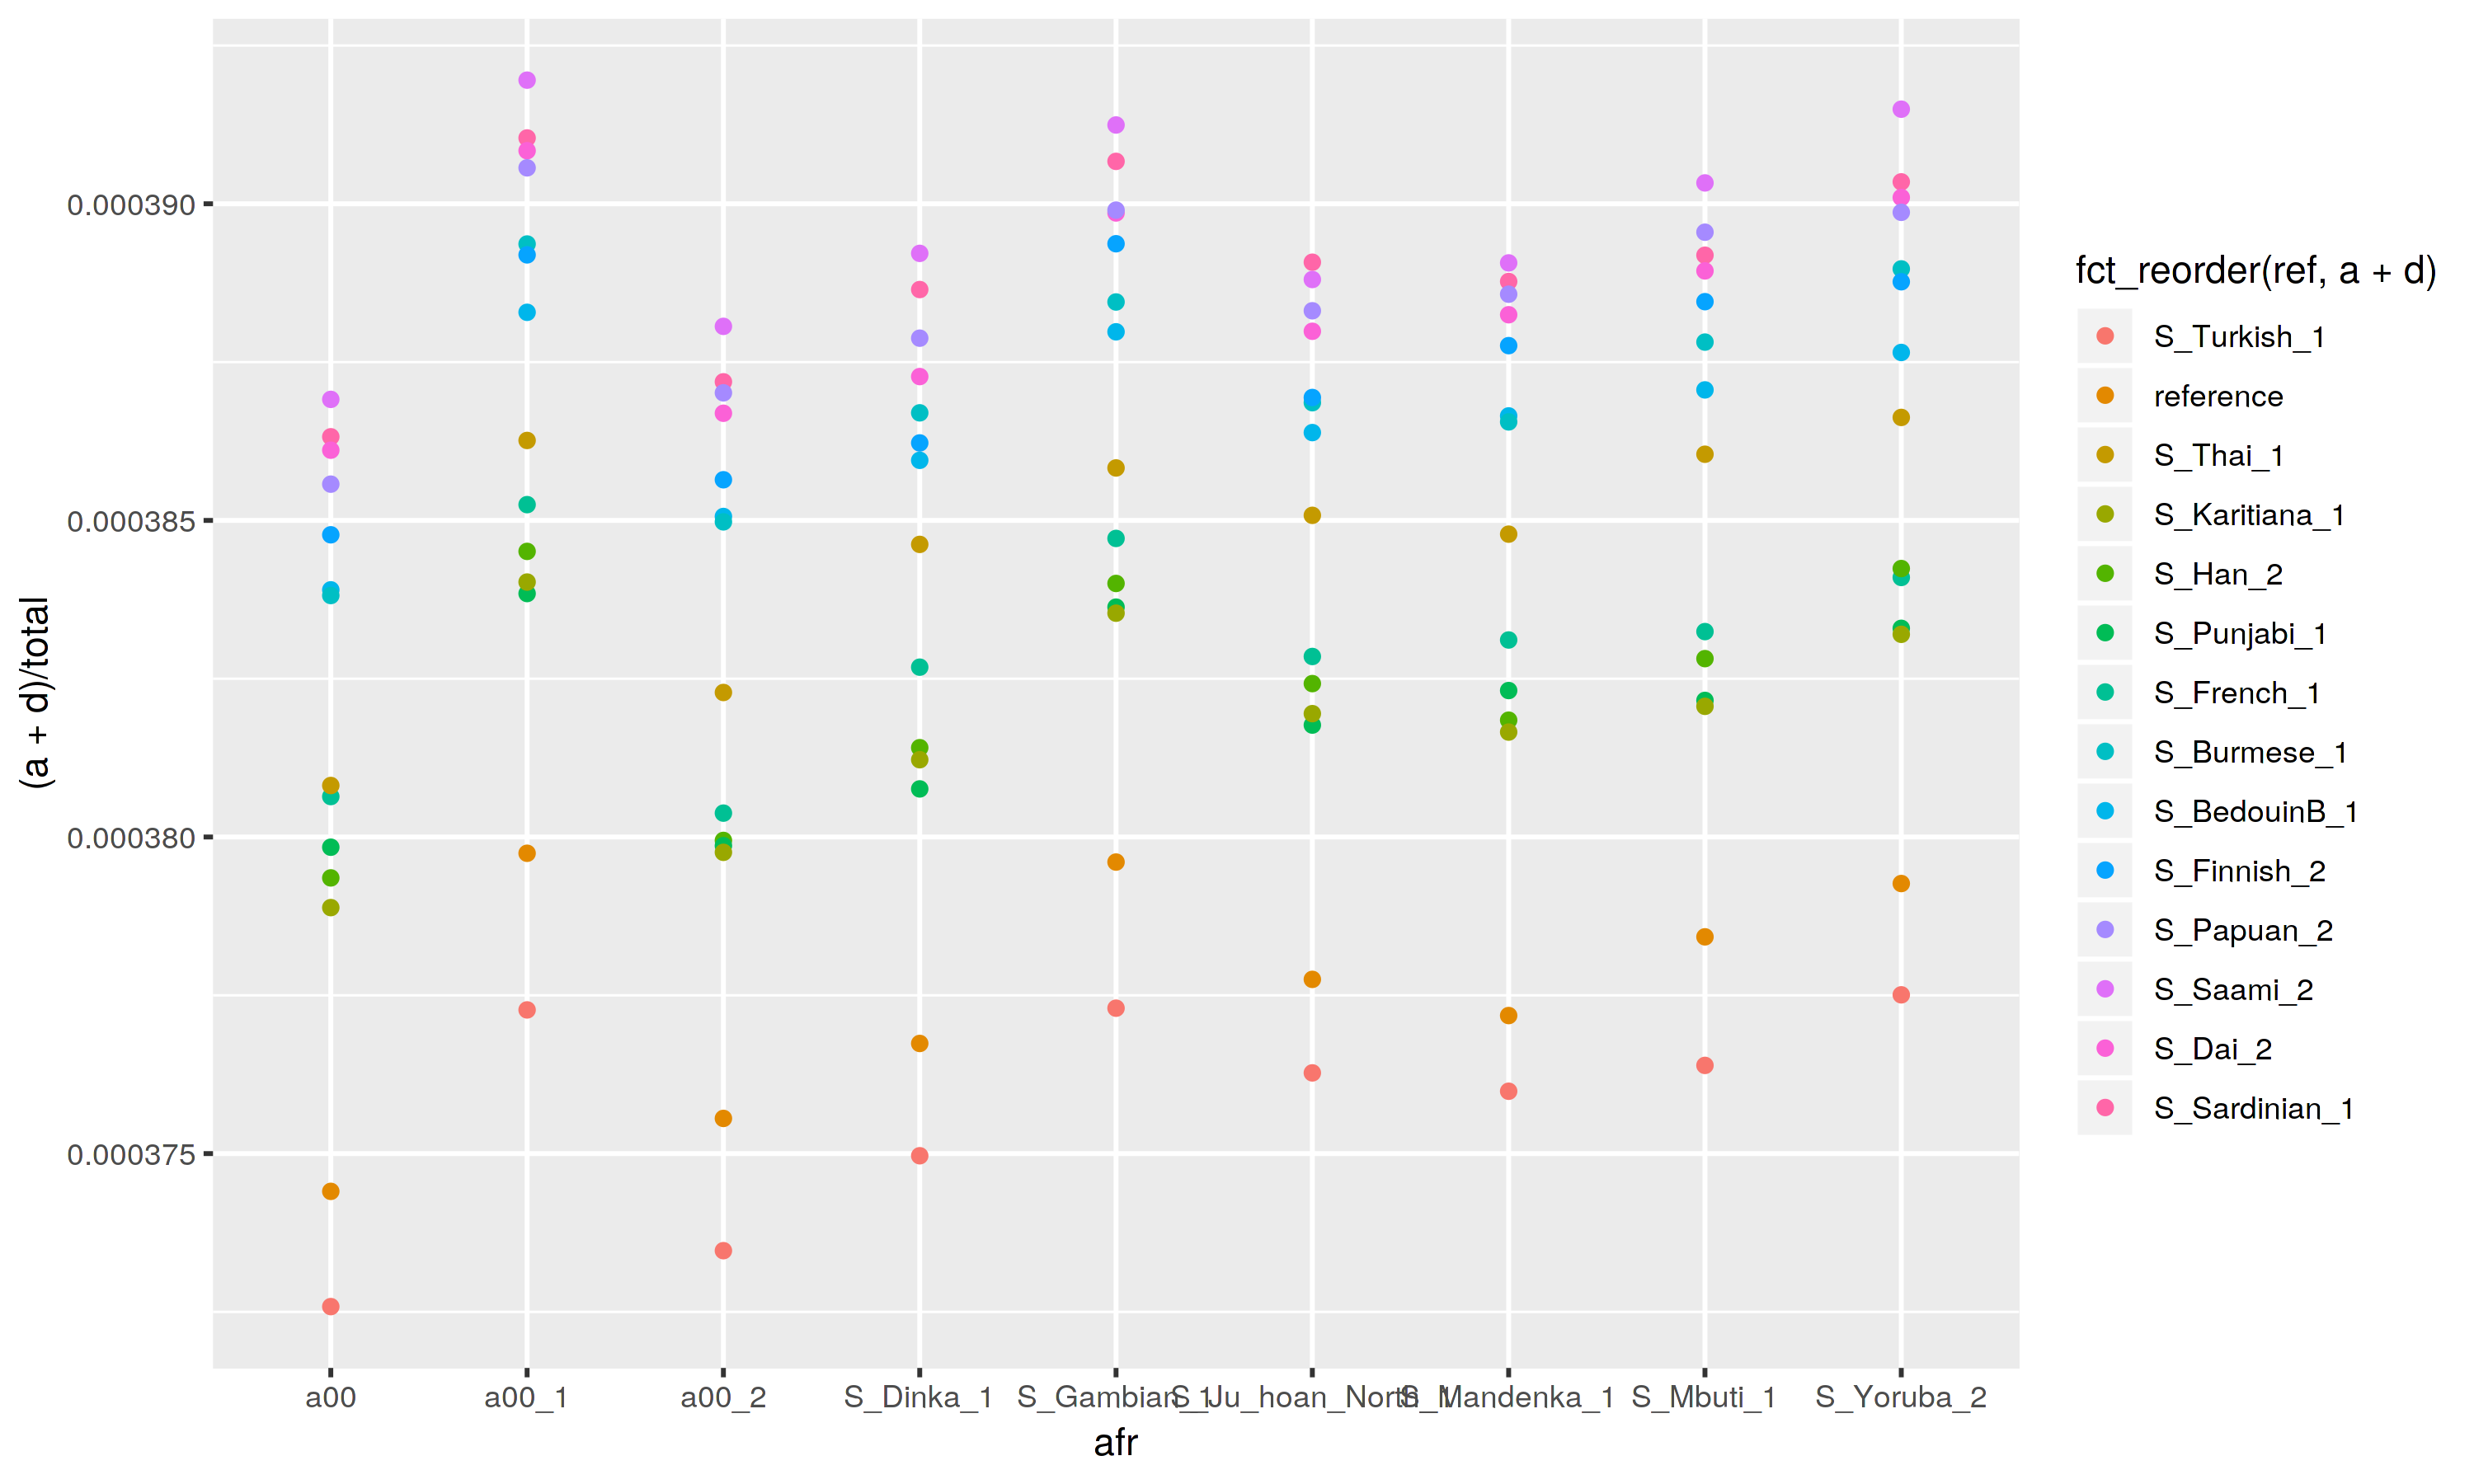

In [97]:
tArchRef %>% filter(archaic == "den8") %>% 
ggplot(aes(afr, (a + d) / total, color = fct_reorder(ref, a + d))) + geom_point()

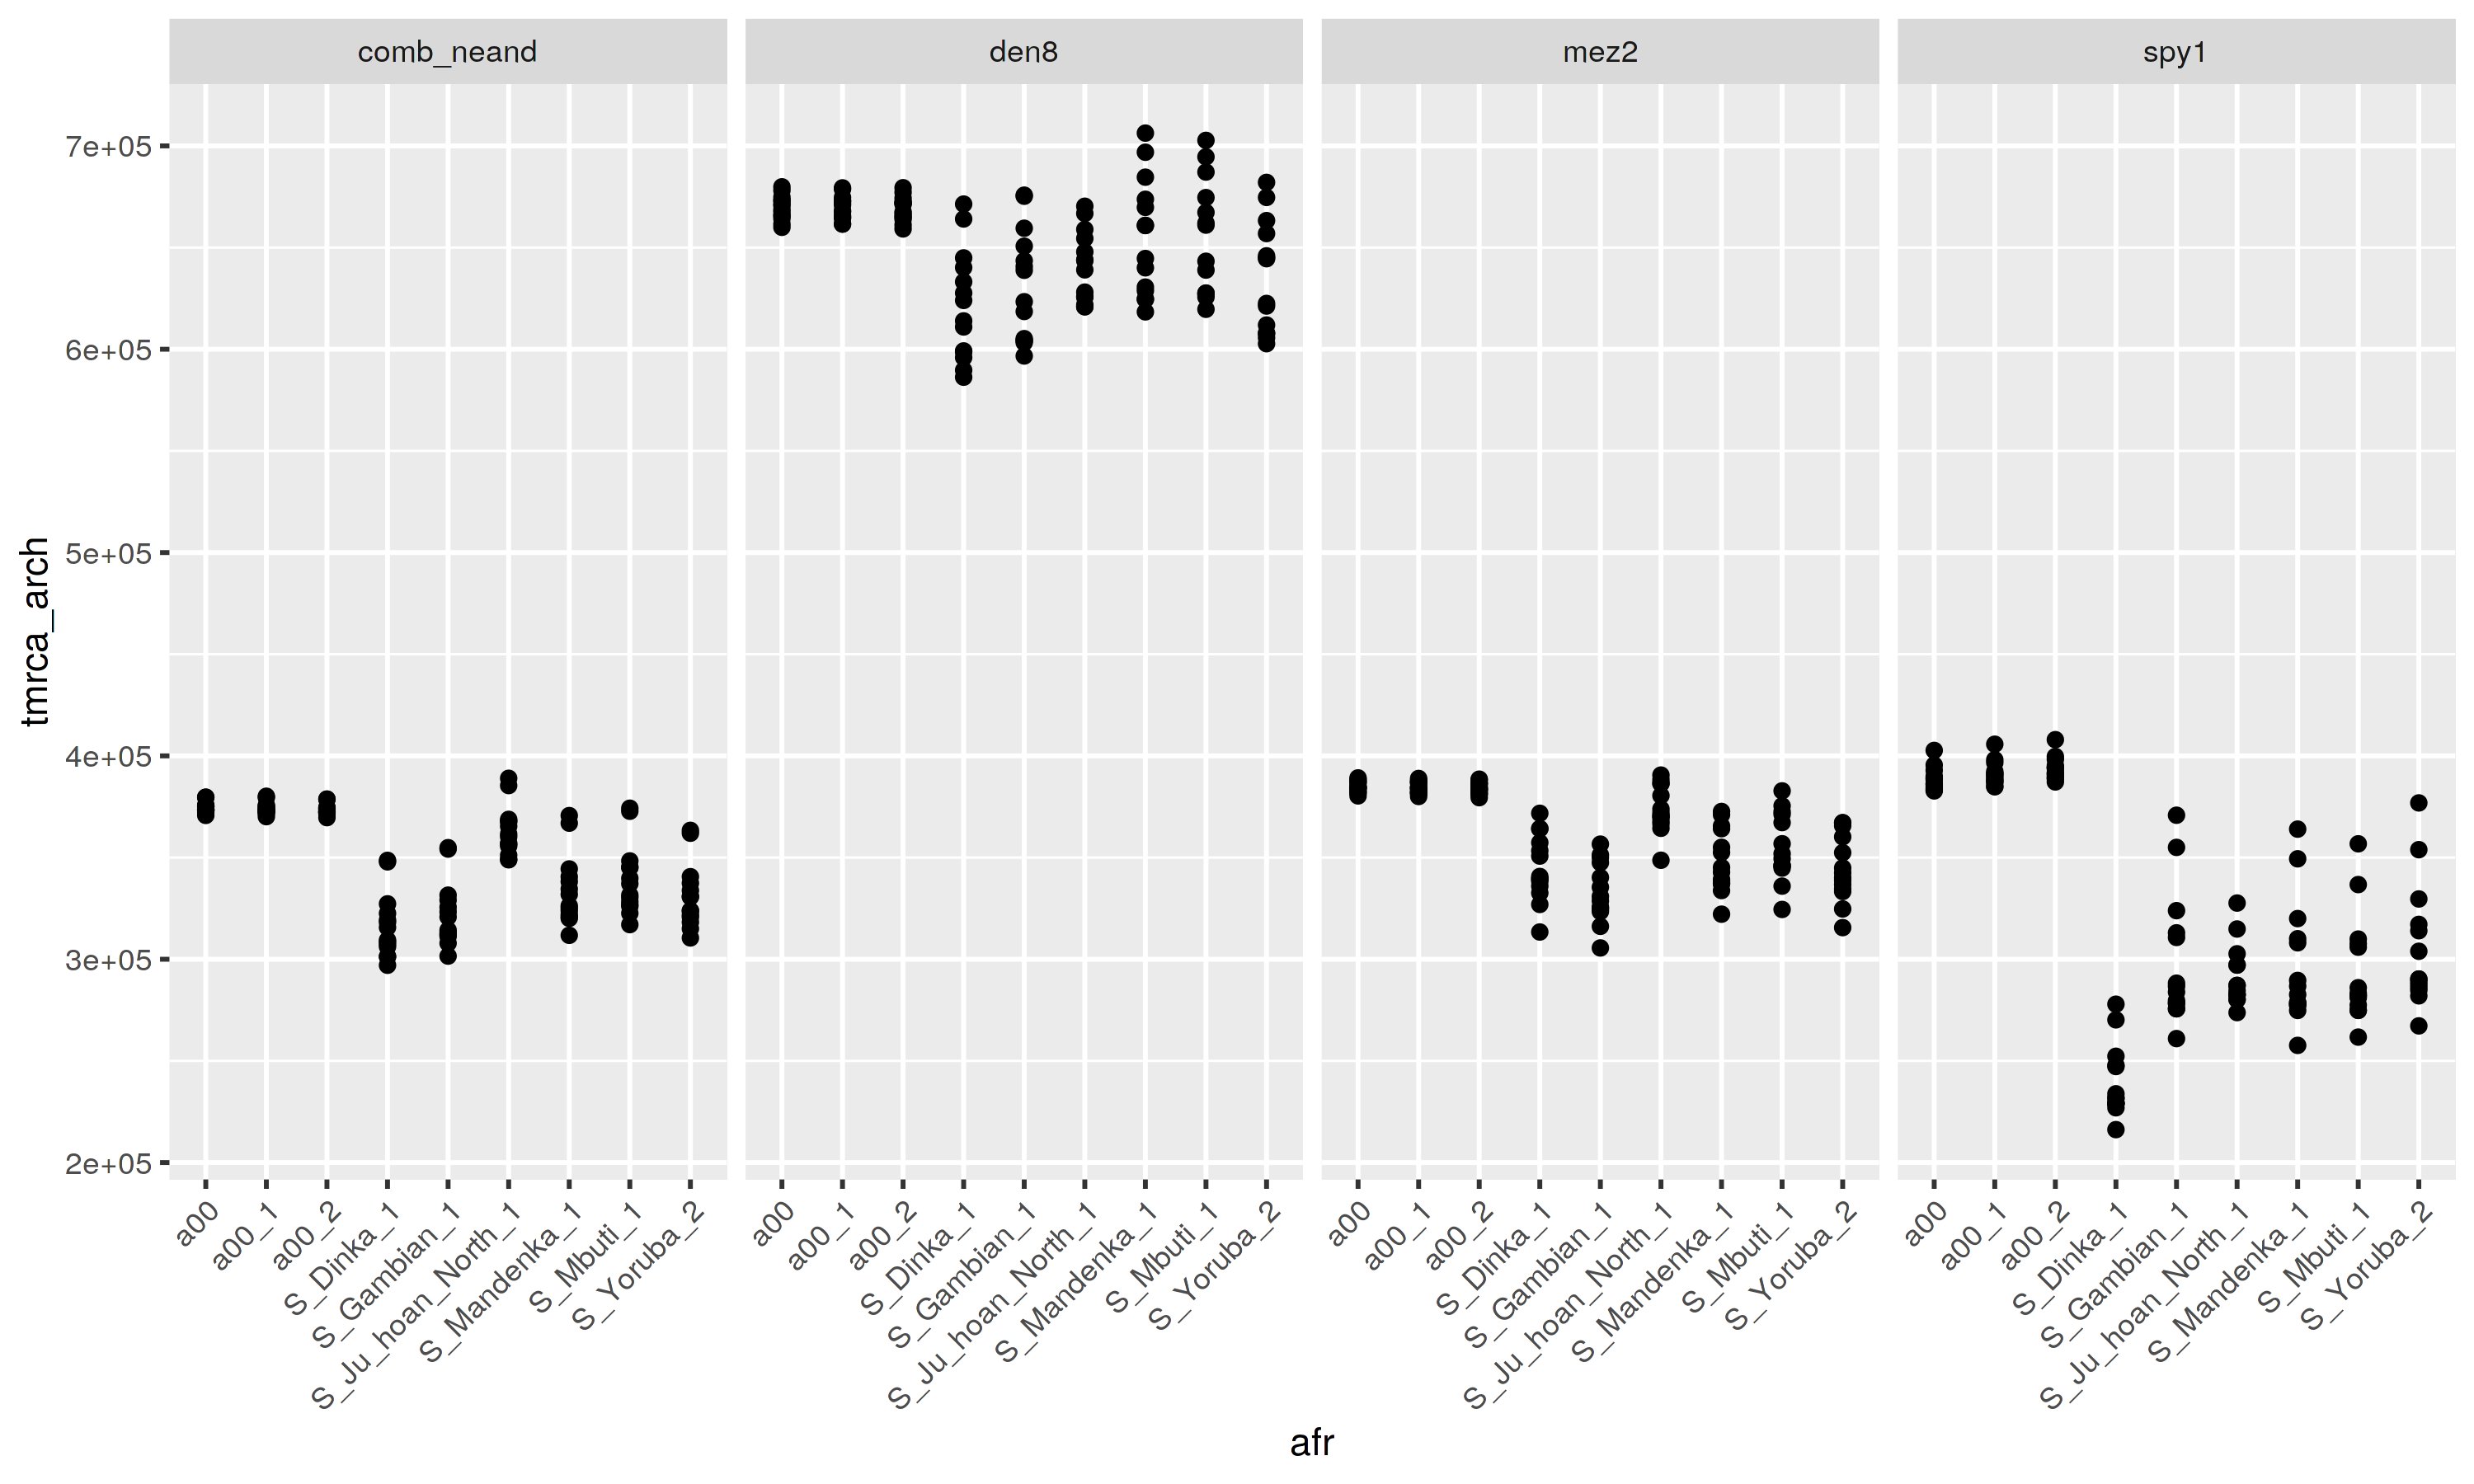

In [109]:
set_dim(10, 6, 300)

tArchRef %>%
ggplot(aes(afr, tmrca_arch)) +
    geom_point() +
    facet_grid(~ archaic) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))